## Some analysis of Delhi Pollution Data

The datasets for pollution data in many countries are readily available and there has been a bunch of research already done on those. I wanted to see if I could do some analysis of the pollution patterns of Indian cities. Unfortunately, I could not find an openly accessible historical pollution dataset for Indian cities. The folks over at [aqicn.org](http://aqicn.org) apparently provide access to institutions but not to individuals. In any case, I was able to locate a fantastic initiative by the [Delhi Pollution Control Committee](http://www.dpccairdata.com/dpccairdata/display/index.php). They provide *raw* pollution data from six sensor clusters inside the city. While the availability could be better, and all sensor clusters do not cover all the metrics, this kind of data is incredibly useful. Kudos to them for having made this available! One problem is that they do not provide historical data, so I had to aggregate the realtime data over time. What follows is some analysis of that data. Hopefully, as the dataset grows, we'd be able to derive more insights about the pollution situation in delhi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

import re

%matplotlib inline

### Munging

The data I am dumping out into the csv file below is pretty raw. It look like:

In [2]:
rawdata = pd.read_csv('./netfile.csv', names=['location', 'metric', 'ts', 'reading', 'guidance'])
rawdata.sort_values(['ts', 'location'])
rawdata.head()

location            metric          ts     reading    guidance
0  Punjabi Bagh           Ammonia  1471960200  19.1 µg/m3   400 µg/m3
1  Punjabi Bagh           Benzene  1471960200   0.2 µg/m3  05 µg/m3 *
2  Punjabi Bagh   Carbon Monoxide  1471960200   1.2 mg/m3    04 mg/m3
3  Punjabi Bagh  Nitrogen Dioxide  1471960200  49.6 µg/m3    80 µg/m3
4  Punjabi Bagh    Nitrogen Oxide  1471960200   4.3 µg/m3           -

In [3]:
rawdata.location.value_counts()

IGI Airport     5580
RK Puram        5301
Punjabi Bagh    5301
Anand Vihar     5301
Civil Lines     3069
Name: location, dtype: int64

In [4]:
rawdata.metric.value_counts()

Nitrogen Dioxide                                      1395
Benzene                                               1395
Toluene                                               1395
Ammonia                                               1395
p-Xylene                                              1395
Nitrogen Oxide                                        1395
Sulphur Dioxide                                       1395
Carbon Monoxide                                       1395
Ozone                                                 1395
Wind Direction                                        1116
Barometric Pressure                                    837
Oxides of Nitrogen                                     837
Ambient Temperature                                    837
Solar Radiation                                        837
Horizontal Wind Speed                                  837
Particulate Matter < 2.5 µg                            837
Relative Humidity                                      8

Some of these metrics sound inferable: for example *Nitrogen Dioxide* and *Nitrogen Oxide* should give a good estimate for *Oxides of Nitrogen* where it does not exist independently. However, we'll look at that later. For now, let's munge this into a more useful dataframe

In [5]:
rawdata['ts'] = pd.to_datetime(rawdata.ts, unit='s')

def mungeReading(x):
    return "".join([t[0] for t in re.findall("[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?", x)][:1]) if not (x.strip() == '-') else "coerce"

rawdata['reading'] = pd.to_numeric(rawdata.reading.apply(mungeReading), errors='coerce')
rawdata['guidance'] = pd.to_numeric(rawdata.guidance.apply(mungeReading), errors='coerce')

rawdata.head()

location            metric                  ts  reading  guidance
0  Punjabi Bagh           Ammonia 2016-08-23 13:50:00     19.1     400.0
1  Punjabi Bagh           Benzene 2016-08-23 13:50:00      0.2       5.0
2  Punjabi Bagh   Carbon Monoxide 2016-08-23 13:50:00      1.2       4.0
3  Punjabi Bagh  Nitrogen Dioxide 2016-08-23 13:50:00     49.6      80.0
4  Punjabi Bagh    Nitrogen Oxide 2016-08-23 13:50:00      4.3       NaN

In [6]:
rawdata.reading.isnull().sum(), len(rawdata.reading), rawdata.guidance.isnull().sum(), len(rawdata.guidance)

(1437, 24552, 14136, 24552)

So that looks reasonable and only a few readings are NaN. I expect that the guidance is a simple function of the metric and should not change that often. Let us check:

In [7]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       1386
                                                   3.0            9
Benzene                                            5.0         1395
Carbon Monoxide                                    4.0          723
                                                   3.0          114
Mass Concentration PM 10 (Previous Day's Average)  100.0        279
Nitrogen Dioxide                                   80.0        1382
                                                   3.0           13
Nitrogen Oxide                                     3.0           13
Oxides of Nitrogen                                 3.0           13
Ozone                                              180.0       1382
                                                   3.0           13
Particulate Matter < 10 µg                         100.0        825
                                                   3.0  

Woah, loooks like there are multiple guidances per metric. For 9 records, the guidance for Ammonia, which ought to be 400 was listed as 3.0. Let us check those records..

In [8]:
rawdata[(rawdata['metric'] == 'Ammonia') & (rawdata['guidance'] == 3.0)]

location   metric                  ts  reading  guidance
6814      RK Puram  Ammonia 2016-08-24 09:15:00      3.0       3.0
15174     RK Puram  Ammonia 2016-08-25 09:05:00      3.0       3.0
15262     RK Puram  Ammonia 2016-08-25 09:25:00      3.0       3.0
15350     RK Puram  Ammonia 2016-08-25 09:30:00      3.0       3.0
15507  Anand Vihar  Ammonia 2016-08-25 10:15:00      3.0       3.0
15595  Anand Vihar  Ammonia 2016-08-25 10:15:00      3.0       3.0
15683  Anand Vihar  Ammonia 2016-08-25 10:15:00      3.0       3.0
23622     RK Puram  Ammonia 2016-08-26 09:10:00      3.0       3.0
23710     RK Puram  Ammonia 2016-08-26 09:30:00      3.0       3.0

In [9]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    12
Name: reading, dtype: int64

In [10]:
rawdata[(rawdata['metric'] == 'Sulphur Dioxide') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    40
Name: reading, dtype: int64

Looks like these are buggy readings, given that the guidance and reading both settle at 3.0, which clearly is an incorrect guidance for these particular metrics. I think that it is a good guess that all records with both guidance and readings at precisely 3.0 are spurious and should be dropped.

In [11]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 3.0) & (rawdata['reading'] != 3.0)]
rawdata.shape

(24552, 5)


(24046, 5)

In [12]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['reading'] == 0.0)]

location                       metric                  ts  reading  \
4765   Punjabi Bagh  Particulate Matter < 2.5 µg 2016-08-24 03:15:00      0.0   
4853   Punjabi Bagh  Particulate Matter < 2.5 µg 2016-08-24 03:25:00      0.0   
4941   Punjabi Bagh  Particulate Matter < 2.5 µg 2016-08-24 03:45:00      0.0   
5029   Punjabi Bagh  Particulate Matter < 2.5 µg 2016-08-24 03:55:00      0.0   
13779      RK Puram  Particulate Matter < 2.5 µg 2016-08-25 05:00:00      0.0   
13867      RK Puram  Particulate Matter < 2.5 µg 2016-08-25 05:10:00      0.0   
13955      RK Puram  Particulate Matter < 2.5 µg 2016-08-25 05:30:00      0.0   
14043      RK Puram  Particulate Matter < 2.5 µg 2016-08-25 05:50:00      0.0   

       guidance  
4765        0.0  
4853        0.0  
4941        0.0  
5029        0.0  
13779       0.0  
13867       0.0  
13955       0.0  
14043       0.0

These zero guidance/readings also look incorrect. Lets drop these as well.

In [13]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 0.0) & (rawdata['reading'] != 0.0)]
rawdata.shape

(24046, 5)


(23388, 5)

In [14]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       1386
Benzene                                            5.0         1389
Carbon Monoxide                                    4.0          721
Mass Concentration PM 10 (Previous Day's Average)  100.0        279
Nitrogen Dioxide                                   80.0        1382
Ozone                                              180.0       1381
Particulate Matter < 10 µg                         100.0        825
Particulate Matter < 2.5 µg                        60.0         685
Sulphur Dioxide                                    80.0        1351
Vertical Wind Speed                                0.1           90
                                                   0.2           33
                                                   0.3           10
                                                   0.4            1
Name: guidance, dtype: int64

I think the data is cleaner now, and as we suspected, there is a single guidance per metric save for *Vertical Wind Speed*, which feels fairly reasonable. For other metrics, the guidance is NaN

In [15]:
rawdata = rawdata[['metric', 'location', 'reading', 'ts']]

### Some simple plots

Lets take our first look at the data for a few metrics.

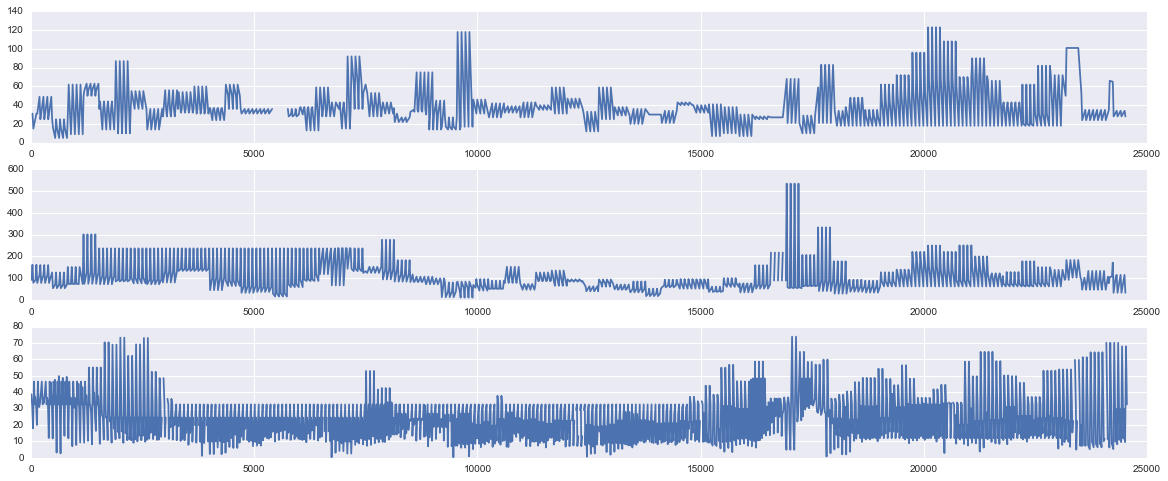

In [16]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(311)
ax1.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 2.5 µg']['reading'])
ax2 = fig.add_subplot(312)
ax2.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 10 µg']['reading'])
ax2 = fig.add_subplot(313)
ax2.plot(rawdata[rawdata['metric'] == 'Ozone']['reading'])

I'd not have expected the peaks to add up to a constant value. There are large flat plateaus seem a bit strange to me, particularly given that this is aggregated data. Of course, the data for different stations is not synchronized from a timestamp perspective. Hence, it could be that the same readings occur at different stations but are staggered.

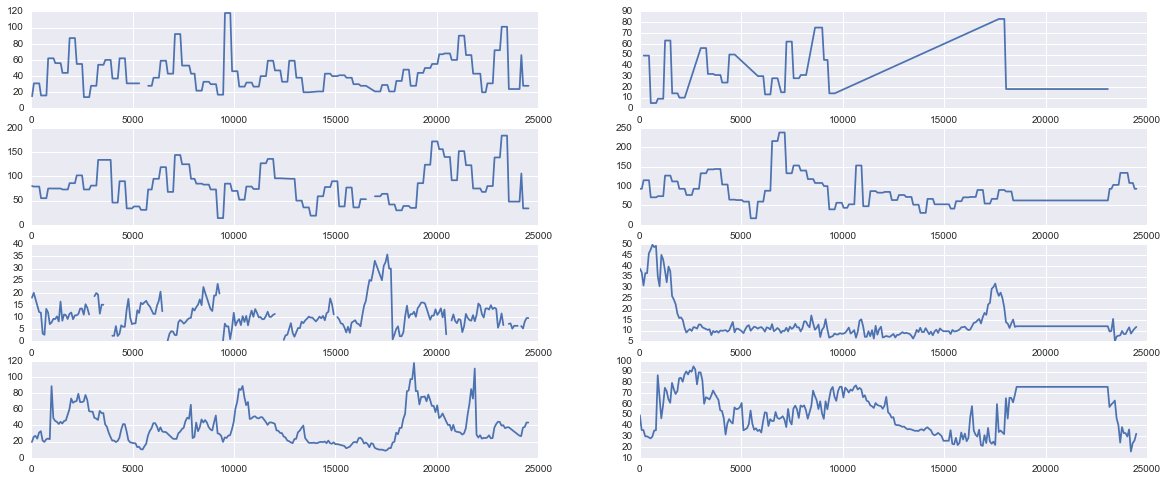

In [20]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(421)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(423)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(425)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(427)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'RK Puram')]['reading'])

ax1 = fig.add_subplot(422)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(424)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(426)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(428)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])

There seems to be some periodicity in the PM 10mcg plot for RK Puram, but that does not hold for Punjabi Bagh. I am surprised by the flat plateaus that are seen in some areas. Could be due to lack of readings in the middle. It is however strange that the Nitrogen Dioxide metric for Punjabi Bagh seems to be constant even after a significant time, particularly given how noisy it has been otherwise. Also, very interestingly, for *Punjabi Bagh*, the plateaus in the data at the very end stack up at the same time for all the metrics. Looks like some issue with the website as stale data might have been returned for a bunch of time.

In [42]:
def getReadings(metrics='all', location='all'):
    allReadings = []
    if location == 'all':
        rd = rawdata
    else:
        rd = rawdata[rawdata['location'] == location]
    if metrics == 'all':
        if location == 'all':
            metrics = list(set(list(rawdata['metric'])))
        else:
            metrics = list(set(list(rawdata[rawdata['location'] == location]['metric'])))
    for m in metrics:
        allReadings.append(np.array(rd[rd['metric'] == m]['reading']))
    #return pd.DataFrame(list(zip(allReadings))).transpose()
    t = pd.DataFrame(allReadings).transpose().dropna()
    t.columns = metrics
    return t

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


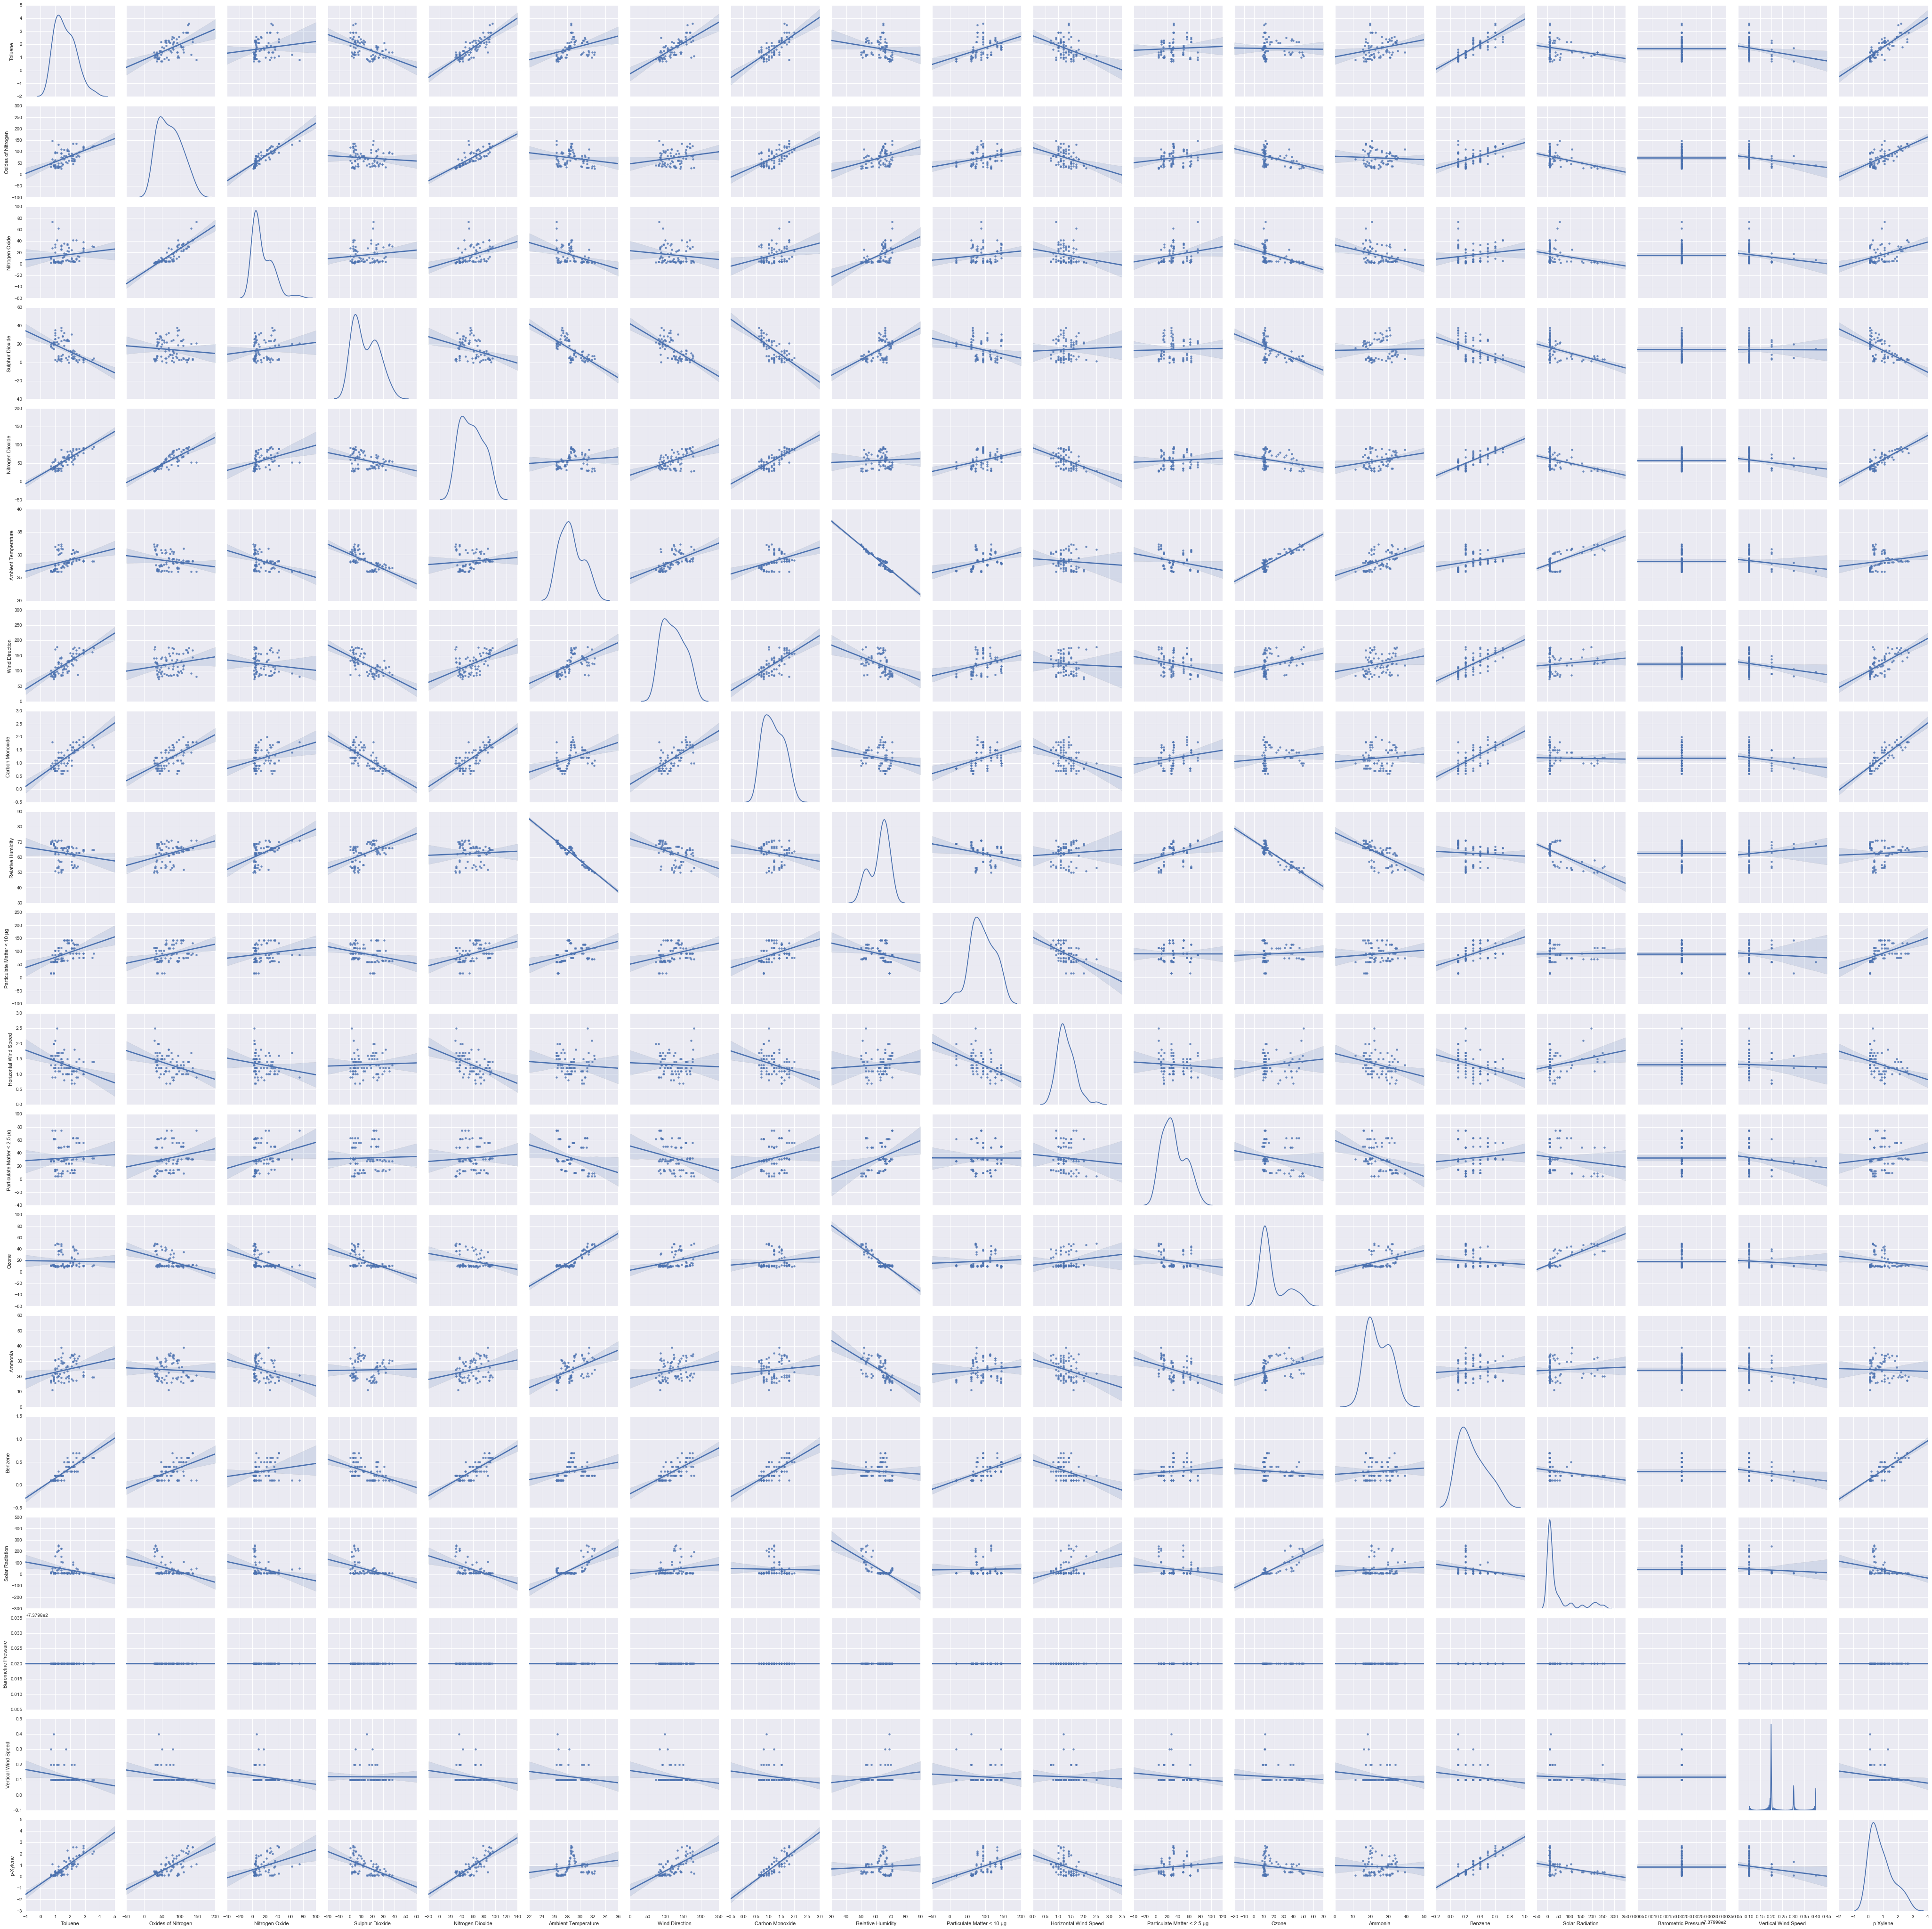

In [38]:
sn.pairplot(getReadings(location='Punjabi Bagh'), size=3, kind="reg", diag_kind="kde")

This pairplot has a wealth of information. Lets quickly note down those pairs with good linear estimators and low error ranges.

1. Ozone vs Relative Humidity
2. $CO$ vs p-Xylene
3. $NO_2$ and $NO$ vs Oxides of $N_2$ (Gives a sense of sanity)
4. Solar Radiation vs N-oxides (Non linear, but somewhat hyperbolic)
5. p-Xylene and Benzene
6. p-Xylene and N-oxides
7. p-Xylene and Toluene
8. Toluene and Benzene

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


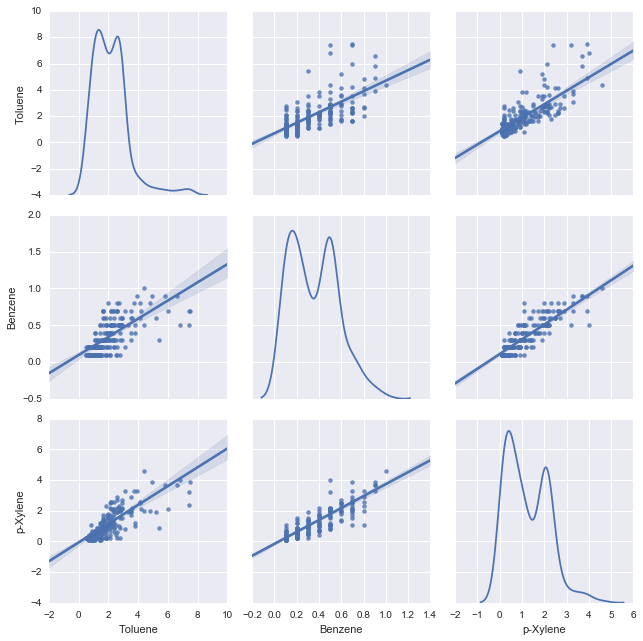

In [43]:
sn.pairplot(getReadings(metrics=['Toluene','Benzene', 'p-Xylene'], location='Punjabi Bagh'), size=3, kind="reg", diag_kind="kde")

Well, the linear relationship is not very strong. I had hoped that since all these contained the benzene ring, they might be well related. Interestingly, I think that we are seeing quantization in the *Benzene* values, suggesting that the sensor is imprecise. Just to confirm, lets check for another station.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


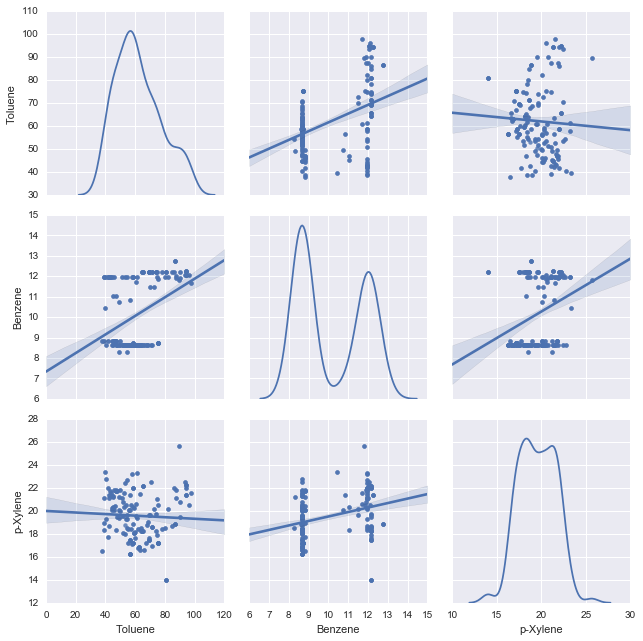

In [44]:
sn.pairplot(getReadings(metrics=['Toluene','Benzene', 'p-Xylene'], location='IGI Airport'), size=3, kind="reg", diag_kind="kde")

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


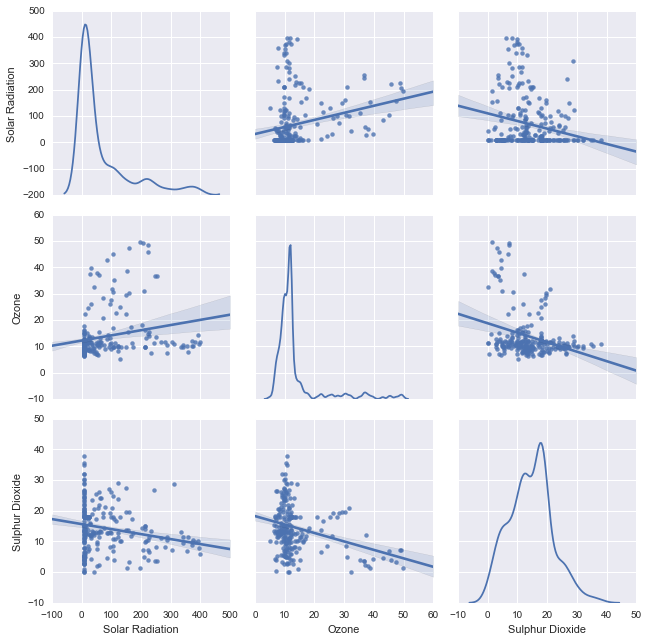

In [52]:
sn.pairplot(getReadings(metrics=['Solar Radiation','Ozone', 'Sulphur Dioxide'], location='Punjabi Bagh'), size=3, kind="reg", diag_kind="kde")

No clear pattern seems to be emerging for this. Let's explore the pairplots for another station.

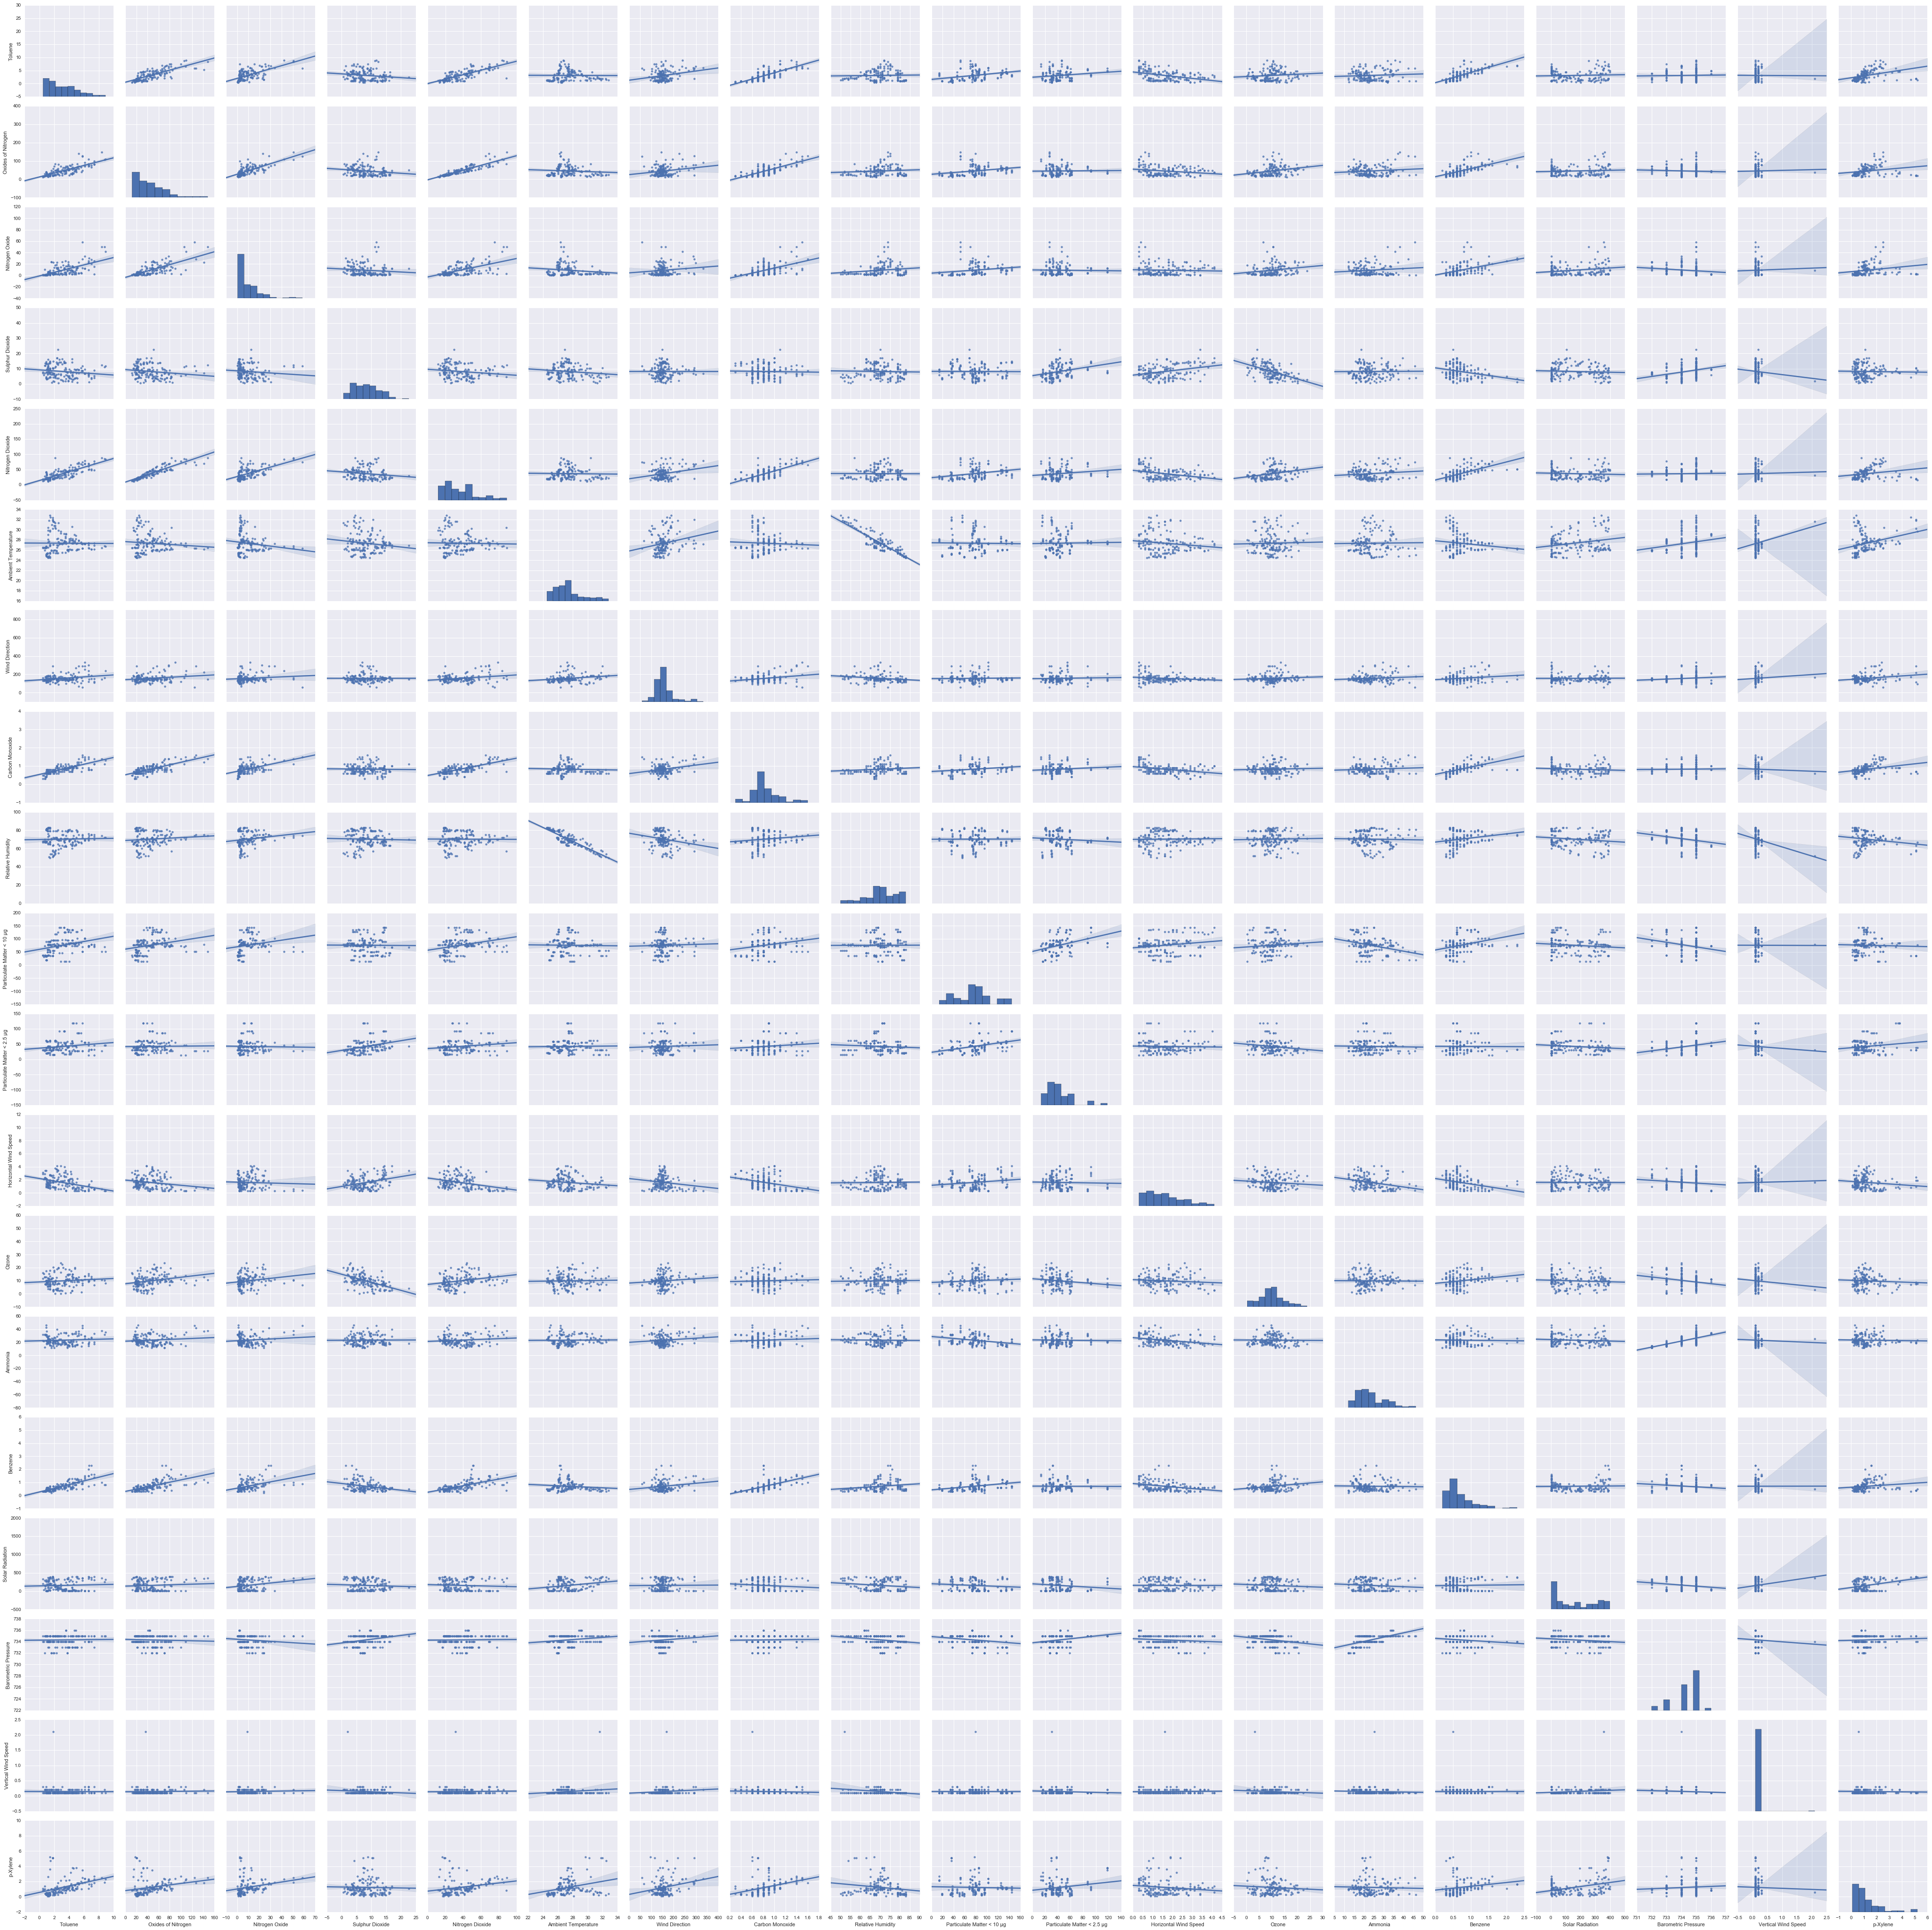

In [53]:
sn.pairplot(getReadings(location='RK Puram'), size=3, kind="reg")

In [83]:
def getCorrelatedMetrics(threshold, dframe, method='spearman'):
    df = dframe.corr(method)
    indices = np.where(df > threshold)
    indices = [(df.index[x], df.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
    return sorted([(t, df[t[1]][t[0]]) for t in indices], key=lambda x: x[1], reverse=True)

def getCommonMetrics(locations='all'):
    if locations == 'all':
        locations = list(set(list(rawdata['location'])))
    metricDict = {}
    for location in locations:
        metricDict[location] = set(rawdata[rawdata['location'] == location]['metric'])
    commonMetrics = set.intersection(*metricDict.values())
    return commonMetrics

In [84]:
getCommonMetrics()

{'Ammonia',
 'Benzene',
 'Carbon Monoxide',
 'Nitrogen Dioxide',
 'Nitrogen Oxide',
 'Ozone',
 'Sulphur Dioxide',
 'Toluene',
 'p-Xylene'}

In [80]:
getCorrelatedMetrics(0.5, getReadings(location='RK Puram'))

[(('Oxides of Nitrogen', 'Nitrogen Dioxide'), 0.94042673312431924),
 (('Toluene', 'Benzene'), 0.7939006482966624),
 (('Toluene', 'Oxides of Nitrogen'), 0.78375415945702143),
 (('Toluene', 'Carbon Monoxide'), 0.77658548307012765),
 (('Toluene', 'Nitrogen Dioxide'), 0.7729008450541982),
 (('Carbon Monoxide', 'Benzene'), 0.76747558131142568),
 (('Oxides of Nitrogen', 'Nitrogen Oxide'), 0.73393183467484546),
 (('Oxides of Nitrogen', 'Benzene'), 0.70658942662185031),
 (('Oxides of Nitrogen', 'Carbon Monoxide'), 0.70091758892690947),
 (('Nitrogen Dioxide', 'Benzene'), 0.68312495251696492),
 (('Toluene', 'p-Xylene'), 0.66469404502778195),
 (('Nitrogen Dioxide', 'Carbon Monoxide'), 0.65066977431362072),
 (('Toluene', 'Nitrogen Oxide'), 0.64415677461656429),
 (('Carbon Monoxide', 'p-Xylene'), 0.56797060825797929),
 (('Ammonia', 'Barometric Pressure'), 0.56006854939012629),
 (('Nitrogen Oxide', 'Nitrogen Dioxide'), 0.55893255508208983),
 (('Nitrogen Oxide', 'Carbon Monoxide'), 0.5413114350378658

In [81]:
getCorrelatedMetrics(0.5, getReadings(location='Punjabi Bagh'))

[(('Oxides of Nitrogen', 'Nitrogen Oxide'), 0.90452879813369069),
 (('Benzene', 'p-Xylene'), 0.88581555124515599),
 (('Toluene', 'Benzene'), 0.87151084726988715),
 (('Carbon Monoxide', 'p-Xylene'), 0.86564080864225246),
 (('Oxides of Nitrogen', 'Nitrogen Dioxide'), 0.83675086477153748),
 (('Toluene', 'p-Xylene'), 0.83197261683487078),
 (('Toluene', 'Nitrogen Dioxide'), 0.80867372100149626),
 (('Nitrogen Dioxide', 'p-Xylene'), 0.77020483803518547),
 (('Nitrogen Dioxide', 'Benzene'), 0.72647322313726459),
 (('Toluene', 'Carbon Monoxide'), 0.70428005317794384),
 (('Toluene', 'Wind Direction'), 0.69426570373177565),
 (('Wind Direction', 'Benzene'), 0.69210896732171157),
 (('Carbon Monoxide', 'Benzene'), 0.68704861106395065),
 (('Nitrogen Dioxide', 'Carbon Monoxide'), 0.67344908320223007),
 (('Ambient Temperature', 'Wind Direction'), 0.67283787446242471),
 (('Ambient Temperature', 'Ozone'), 0.67005151403895857),
 (('Particulate Matter < 10 µg', 'p-Xylene'), 0.66511593611930897),
 (('Wind Di

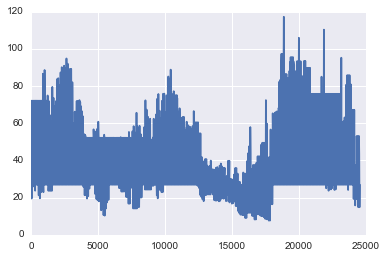

In [69]:
plt.plot(rawdata[rawdata['metric'] == 'Nitrogen Dioxide']['reading'])

In [106]:
data = rawdata[['location', 'metric', 'ts', 'reading']].dropna()
data.groupby(['location', 'metric']).describe()

reading
location    metric                               
Anand Vihar Ambient Temperature count  279.000000
                                mean    30.913262
                                std      2.303689
                                min     27.600000
                                25%     28.800000
                                50%     31.400000
                                75%     32.200000
                                max     37.000000
            Ammonia             count  276.000000
                                mean    42.236232
                                std     17.717709
                                min     18.800000
                                25%     33.400000
                                50%     34.400000
                                75%     44.225000
                                max    101.600000
            Barometric Pressure count  279.000000
                                mean   740.000000
                                std      0.000000
                                min    740.000000
                                25%    740.000000
                                50%    740.000000
                                75%    740.000000
                                max    740.000000
            Benzene             count  276.000000
                                mean     6.300000
                                std      5.541447
                                min      0.900000
                                25%      2.500000
                                50%      5.900000
...                                           ...
RK Puram    Toluene             std      4.610904
                                min      0.400000
                                25%      1.500000
                                50%      3.500000
                                75%      6.100000
                                max     18.100000
            Vertical Wind Speed count  203.000000
                                mean     0.139409
                                std      0.148669
                                min      0.100000
                                25%      0.100000
                                50%      0.100000
                                75%      0.200000
                                max      2.100000
            Wind Direction      count  279.000000
                                mean   182.666667
                                std     69.570832
                                min     16.000000
                                25%    138.500000
                                50%    156.000000
                                75%    246.500000
                                max    349.000000
            p-Xylene            count  242.000000
                                mean     2.178926
                                std      2.419288
                                min      0.100000
                                25%      0.700000
                                50%      1.200000
                                75%      2.475000
                                max      9.300000

[664 rows x 1 columns]